# Azure AI Agent service - Code interpreter

<img src="https://learn.microsoft.com/en-us/azure/ai-services/agents/media/agent-service-the-glue.png" width=800>

> https://learn.microsoft.com/en-us/azure/ai-services/agents/

In [1]:
#%pip install ipyplot
#%pip install matplotlib

## Load all dependencies

In [2]:
import glob
import json
import ipyplot
import matplotlib.pyplot as plt
import os
import sys
import time

from azure.ai.agents import AgentsClient 
from azure.identity import DefaultAzureCredential
from azure.ai.agents.models import CodeInterpreterTool, FilePurpose, ListSortOrder
from dotenv import load_dotenv
from openai import AzureOpenAI
from PIL import Image
from pathlib import Path

In [3]:
load_dotenv()

True

## Connect to AI Foundry Project 

In [4]:
endpoint = os.getenv("PROJECT_ENDPOINT")
print(f"Using endpoint: {endpoint}")
credential = DefaultAzureCredential()

project_client = AgentsClient(endpoint=endpoint, credential=credential)

Using endpoint: https://aq-ai-foundry-sweden-central.services.ai.azure.com/api/projects/firstProject


## Get example file

In [5]:
DATA_DIR = "data"

os.makedirs(DATA_DIR, exist_ok=True)

output_file = os.path.join(DATA_DIR, "titanic.csv")

In [6]:
!wget https://raw.githubusercontent.com/datasciencedojo/datasets/refs/heads/master/titanic.csv -O $output_file

--2025-06-10 16:56:38--  https://raw.githubusercontent.com/datasciencedojo/datasets/refs/heads/master/titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘data/titanic.csv’

data/titanic.csv    100%[===================>]  58.89K  --.-KB/s    in 0.02s   

2025-06-10 16:56:38 (3.32 MB/s) - ‘data/titanic.csv’ saved [60302/60302]



In [7]:
model = "gpt-4o-mini"

## Upload file to agent

In [8]:
file = project_client.files.upload_and_poll(file_path=output_file,
                                                  purpose=FilePurpose.AGENTS)

print(f"Uploaded file, file ID: {file.id}")

Uploaded file, file ID: assistant-KL8mc9vjvSW2GiigCXV5La


## Create and agent with code interpreter tool

In [9]:
    code_interpreter = CodeInterpreterTool(file_ids=[file.id])

    # Create agent with code interpreter tool and tools_resources
    agent = project_client.create_agent(
        model=os.environ["MODEL_DEPLOYMENT_NAME"],
        name="my-agent",
        instructions="You are helpful agent",
        tools=code_interpreter.definitions,
        tool_resources=code_interpreter.resources,
    )
    print(f"Created agent, agent ID: {agent.id} File ID: {file.id}")

Created agent, agent ID: asst_UetOZ4mtIxZ8sjF4FF2IvcLg File ID: assistant-KL8mc9vjvSW2GiigCXV5La


## Create a thread for the agent to run

In [10]:
# create a thread
thread = project_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

prompt = "Plot a correlation matrix using the blues theme"

# create a message
message = project_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

messages = project_client.messages.list(thread_id=thread.id)
print(f"Messages: {messages}")

Created thread, thread ID: thread_wgLq2veKPy37hwLWfp5dID1q
Created message, message ID: msg_logU8bq3SDssrTURwoHlFNH1
Messages: <iterator object azure.core.paging.ItemPaged at 0x121523380>


## Run the code interpreter agent

In [11]:
# create a run for the agent
run = project_client.runs.create_and_process(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

Created run, run ID: run_DF7sf2GQeM89rMB3QOR66NjH


## Get the messages genrated by the run

In [12]:
messages = project_client.messages.list(thread_id=thread.id)
print(f"Messages: {messages}")

# Fetch and log all messages
messages = project_client.messages.list(thread_id=thread.id, order=ListSortOrder.ASCENDING)

# Print last messages from the thread
for msg in messages:
    if msg.text_messages:
        last_text = msg.text_messages[-1]
        print(f"{msg.role}: {last_text.text.value}")

Messages: <iterator object azure.core.paging.ItemPaged at 0x12155d090>
MessageRole.USER: Plot a correlation matrix using the blues theme
MessageRole.AGENT: Let me first inspect the file to understand its structure and data. Then, I'll generate a correlation matrix plot using the blues color theme.
MessageRole.AGENT: The file appears to be the Titanic dataset. I will plot a correlation matrix for the numerical columns using a blue color theme. Let's create that plot.
MessageRole.AGENT: Here is the correlation matrix of the numerical columns, visualized using the "Blues" color theme. If you'd like any additional analyses or a focus on specific variables, please let me know!


## Save image(s) generated by the run

In [13]:
IMAGES_DIR = "images"

images_list = []

# [START get_messages_and_save_files]
messages = project_client.messages.list(thread_id=thread.id)
print(f"Messages: {messages}")

for msg in messages:
        # Save every image file in the message
        for img in msg.image_contents:
            file_id = img.image_file.file_id
            file_name = f"./images/{file_id}_image_file.png"
            project_client.files.save(file_id=file_id, file_name=file_name)
            print(f"Saved image file to: {Path.cwd() / file_name}")

        # Print details of every file-path annotation
        for ann in msg.file_path_annotations:
            print("File Paths:")
            print(f"  Type: {ann.type}")
            print(f"  Text: {ann.text}")
            print(f"  File ID: {ann.file_path.file_id}")
            print(f"  Start Index: {ann.start_index}")
            print(f"  End Index: {ann.end_index}")
        # [END get_messages_and_save_files]
        # Print last messages from the thread
        for msg in messages:
            if msg.text_messages:
                last_text = msg.text_messages[-1]
                print(f"{msg.role}: {last_text.text.value}")


Messages: <iterator object azure.core.paging.ItemPaged at 0x1212e3e10>
Saved image file to: /Users/arturoquiroga/GITHUB/AZURE AI AGENT SERVICE/1_Azure Agent Service/NOTEBOOKS/images/assistant-Hsao4n8C8rFZpheX1XHy3Z_image_file.png
MessageRole.AGENT: The file appears to be the Titanic dataset. I will plot a correlation matrix for the numerical columns using a blue color theme. Let's create that plot.
MessageRole.AGENT: Let me first inspect the file to understand its structure and data. Then, I'll generate a correlation matrix plot using the blues color theme.
MessageRole.USER: Plot a correlation matrix using the blues theme


## Display image

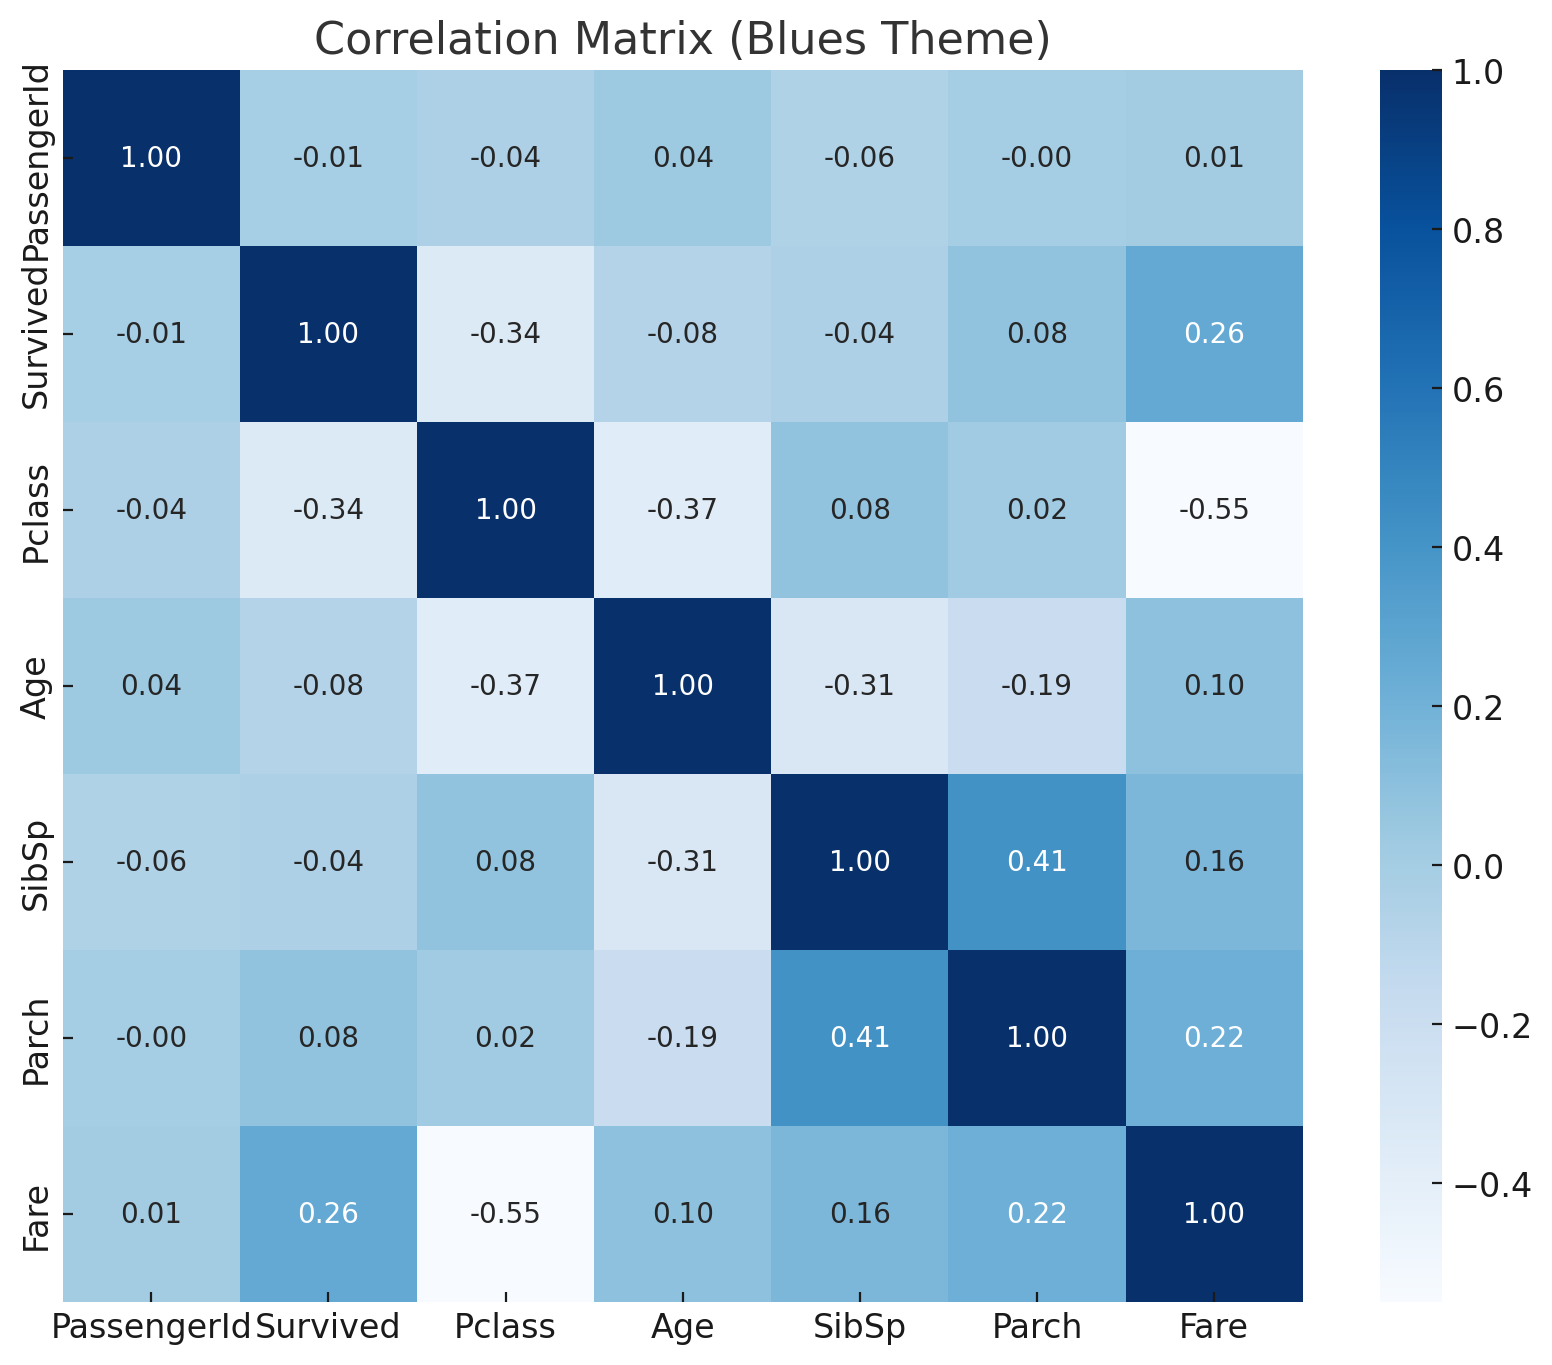

In [16]:
from IPython.display import Image, display
from pathlib import Path

file_path = Path.cwd() / file_name
display(Image(filename=str(file_path)))


## Example

In [17]:
# create a thread
thread = project_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

prompt = "Generate a survival count by Gender plot and the age distribution. Use some blues colors."

# create a message
message = project_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

Created thread, thread ID: thread_dza3pcs9UfLBzQvaXVT7w7FE
Created message, message ID: msg_foRBmbWaC31yogcDi9i5xDQ3


In [ ]:
# create a run for the agent
run = project_client.runs.create_and_process(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

run.usage

Created run, run ID: run_f4i7MUur5UvpWUKMZgbQrImp


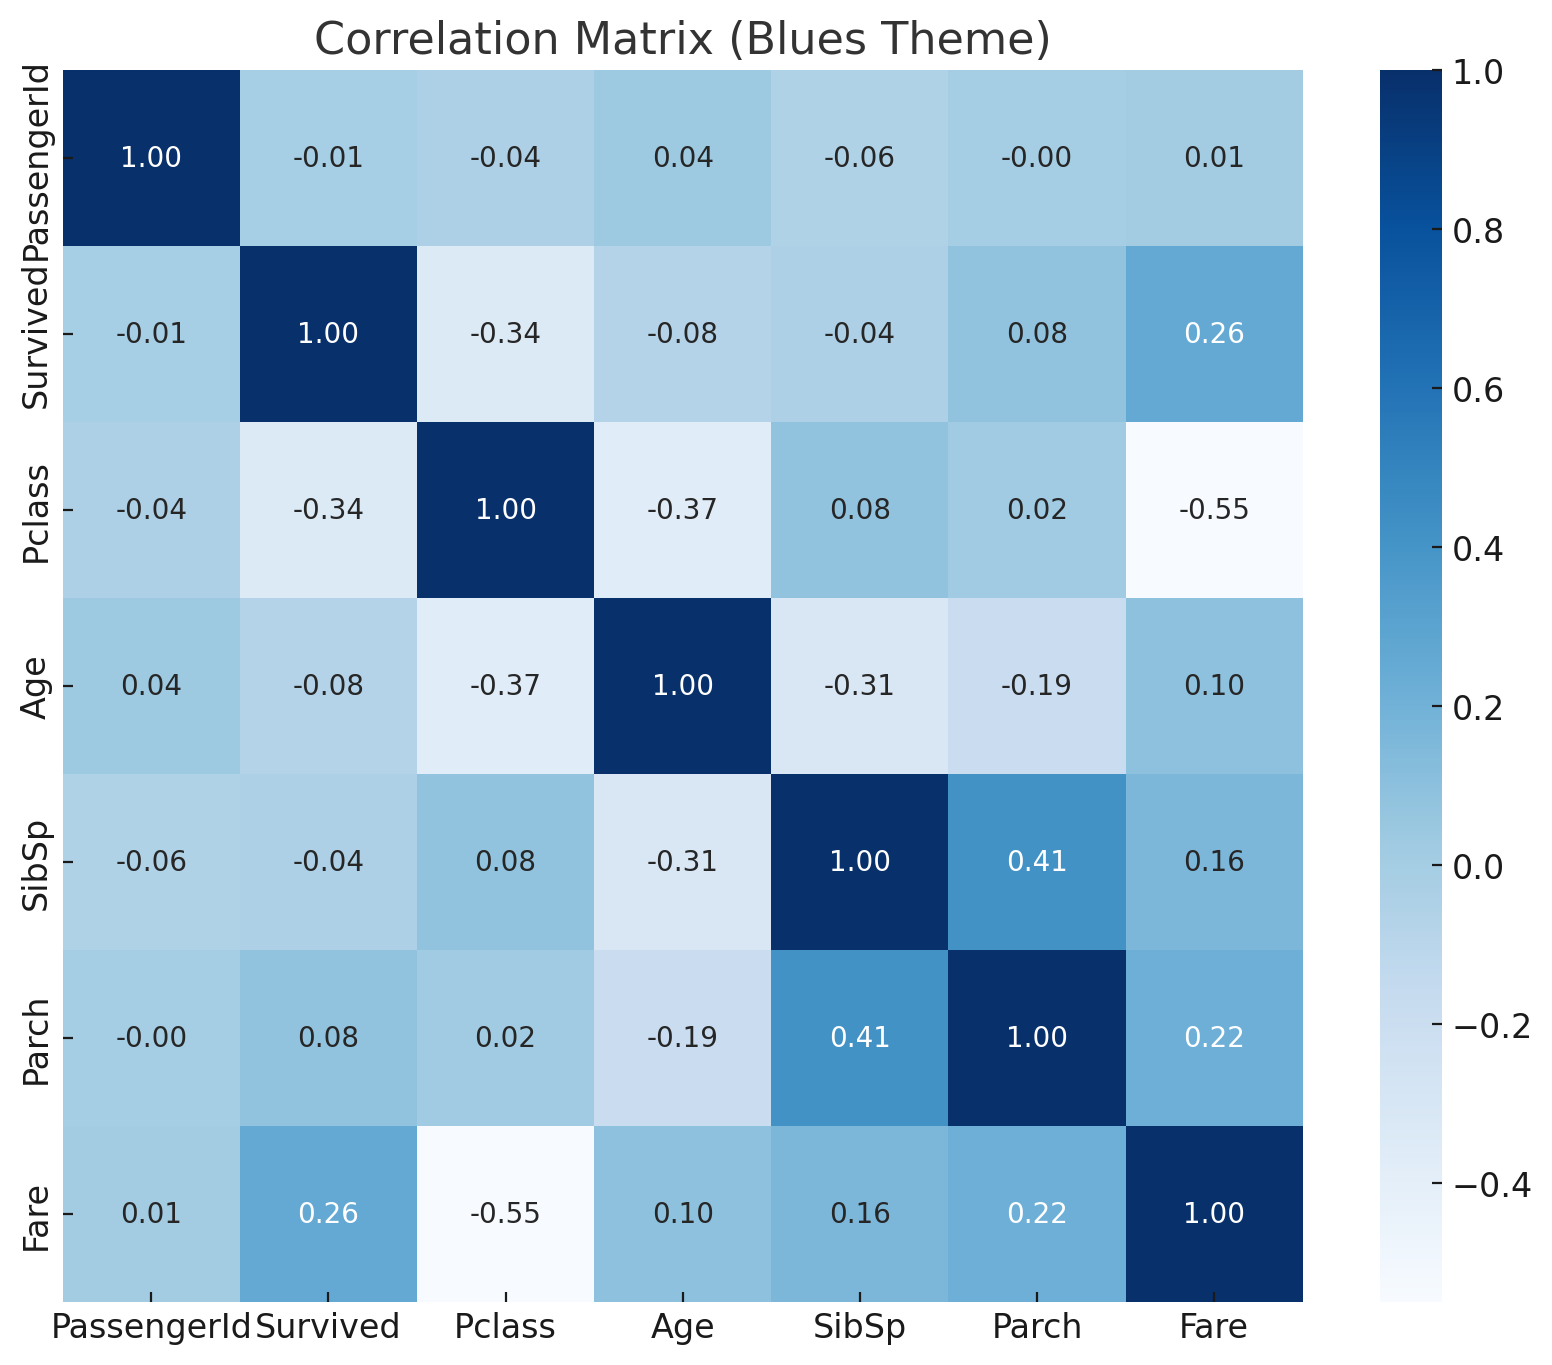

In [20]:
from IPython.display import Image, display
from pathlib import Path

file_path = Path.cwd() / file_name
display(Image(filename=str(file_path)))

## Example

In [21]:
# create a thread
thread = project_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

prompt = "Generate a bivariate analysis of survival and pclass. Use some greens colors."

# create a message
message = project_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

Created thread, thread ID: thread_wmWq1nNJUIwvo7MoDWLSBzlR
Created message, message ID: msg_gmCZHWhhZZNlqiSOrsQB4rXm


In [22]:
# create a run for the agent
run = project_client.runs.create_and_process(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

Created run, run ID: run_Ag0r7PRZQCXWUV6vkFEyukVW


In [23]:
run.usage

{'prompt_tokens': 3262, 'completion_tokens': 559, 'total_tokens': 3821, 'prompt_token_details': {'cached_tokens': 0}}

In [24]:
    IMAGES_DIR = "images"

    images_list = []

    # [START get_messages_and_save_files]
    messages = project_client.messages.list(thread_id=thread.id)
    print(f"Messages: {messages}")

    for msg in messages:
        # Save every image file in the message
        for img in msg.image_contents:
            file_id = img.image_file.file_id
            file_name = f"{file_id}_image_file.png"
            project_client.files.save(file_id=file_id, file_name=file_name)
            print(f"Saved image file to: {Path.cwd() / file_name}")

        # Print details of every file-path annotation
        for ann in msg.file_path_annotations:
            print("File Paths:")
            print(f"  Type: {ann.type}")
            print(f"  Text: {ann.text}")
            print(f"  File ID: {ann.file_path.file_id}")
            print(f"  Start Index: {ann.start_index}")
            print(f"  End Index: {ann.end_index}")
        # [END get_messages_and_save_files]
        # Print last messages from the thread
        for msg in messages:
            if msg.text_messages:
                last_text = msg.text_messages[-1]
                print(f"{msg.role}: {last_text.text.value}")

Messages: <iterator object azure.core.paging.ItemPaged at 0x1215b8510>
Saved image file to: /Users/arturoquiroga/GITHUB/AZURE AI AGENT SERVICE/1_Azure Agent Service/NOTEBOOKS/assistant-BqaiSU7Vex68S2i4zo1r8c_image_file.png
MessageRole.AGENT: The relevant variables are `Survived` (0 = Did not survive, 1 = Survived) and `Pclass` (passenger class, 1 = First, 2 = Second, 3 = Third).

Let's proceed with a bivariate analysis by:
1. Creating a crosstab of `Pclass` vs. `Survived`.
2. Visualizing survival rates by class using a green-themed stacked bar chart.
MessageRole.AGENT: Let's perform a bivariate analysis of the `survival` (commonly `Survived`) and `pclass` (passenger class) variables from your dataset.

Here's the general process I will follow:

1. Load your data and inspect the variable names.
2. Create a contingency table analyzing the relationship between `Survived` and `Pclass`.
3. Visualize the relationship using an appropriate plot (e.g., stacked bar chart), using a green color pa

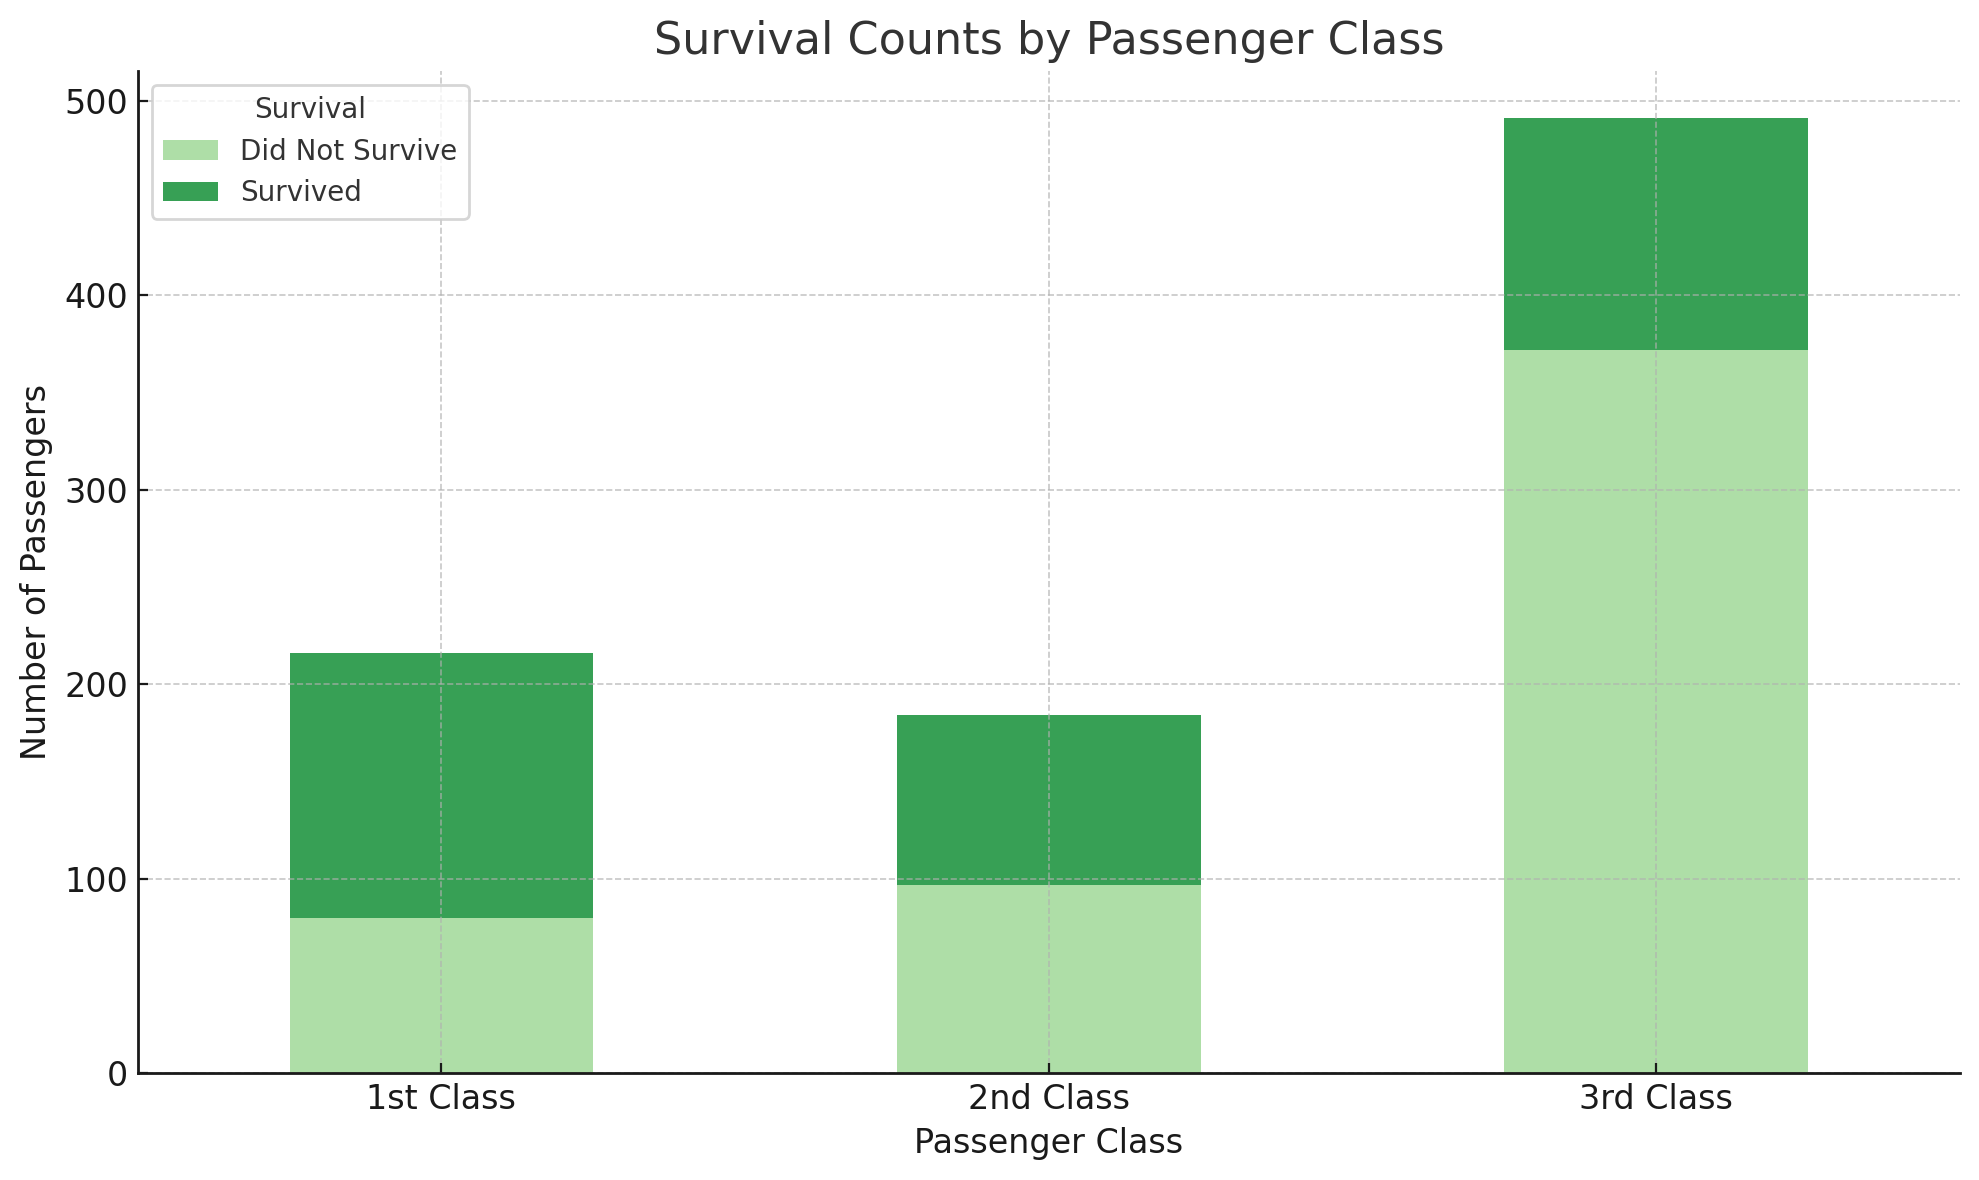

In [25]:
from IPython.display import Image, display
from pathlib import Path

file_path = Path.cwd() / file_name
display(Image(filename=str(file_path)))

## Example

In [26]:
# create a thread
thread = project_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

prompt = "Generate a violin plot of Pclass by Age and Gender. Use lime and cyan colors."

# create a message
message = project_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

Created thread, thread ID: thread_bxJ9x5BAQth8vHdZS22G9qfP
Created message, message ID: msg_R83YA9TyX7LHJ4mrkFGU54WE


In [27]:
# create a run for the agent
run = project_client.runs.create_and_process(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

run.usage

Created run, run ID: run_I7lv4IcnE6VsT4PpkZESVx8C


{'prompt_tokens': 2984, 'completion_tokens': 356, 'total_tokens': 3340, 'prompt_token_details': {'cached_tokens': 0}}

In [28]:
    IMAGES_DIR = "images"

    images_list = []

    # [START get_messages_and_save_files]
    messages = project_client.messages.list(thread_id=thread.id)
    print(f"Messages: {messages}")

    for msg in messages:
        # Save every image file in the message
        for img in msg.image_contents:
            file_id = img.image_file.file_id
            file_name = f"{file_id}_image_file.png"
            project_client.files.save(file_id=file_id, file_name=file_name)
            print(f"Saved image file to: {Path.cwd() / file_name}")

        # Print details of every file-path annotation
        for ann in msg.file_path_annotations:
            print("File Paths:")
            print(f"  Type: {ann.type}")
            print(f"  Text: {ann.text}")
            print(f"  File ID: {ann.file_path.file_id}")
            print(f"  Start Index: {ann.start_index}")
            print(f"  End Index: {ann.end_index}")
        # [END get_messages_and_save_files]
        # Print last messages from the thread
        for msg in messages:
            if msg.text_messages:
                last_text = msg.text_messages[-1]
                print(f"{msg.role}: {last_text.text.value}")

Messages: <iterator object azure.core.paging.ItemPaged at 0x121566e70>
Saved image file to: /Users/arturoquiroga/GITHUB/AZURE AI AGENT SERVICE/1_Azure Agent Service/NOTEBOOKS/assistant-1HQ8njG6wsERs4wWn91dWo_image_file.png
MessageRole.AGENT: The dataset contains the columns: `Pclass`, `Age`, and `Sex` (which represents gender). Now, I'll generate a violin plot displaying the distribution of Age by Pclass and Sex, using lime and cyan for the two sexes.
MessageRole.AGENT: I see you've uploaded a file. I'll first inspect the contents to identify the columns and ensure we have `Pclass`, `Age`, and `Gender` (which might be called `Sex`).

Then I’ll proceed to create the violin plot using the specified colors (lime and cyan). Let's start by previewing the data.
MessageRole.USER: Generate a violin plot of Pclass by Age and Gender. Use lime and cyan colors.


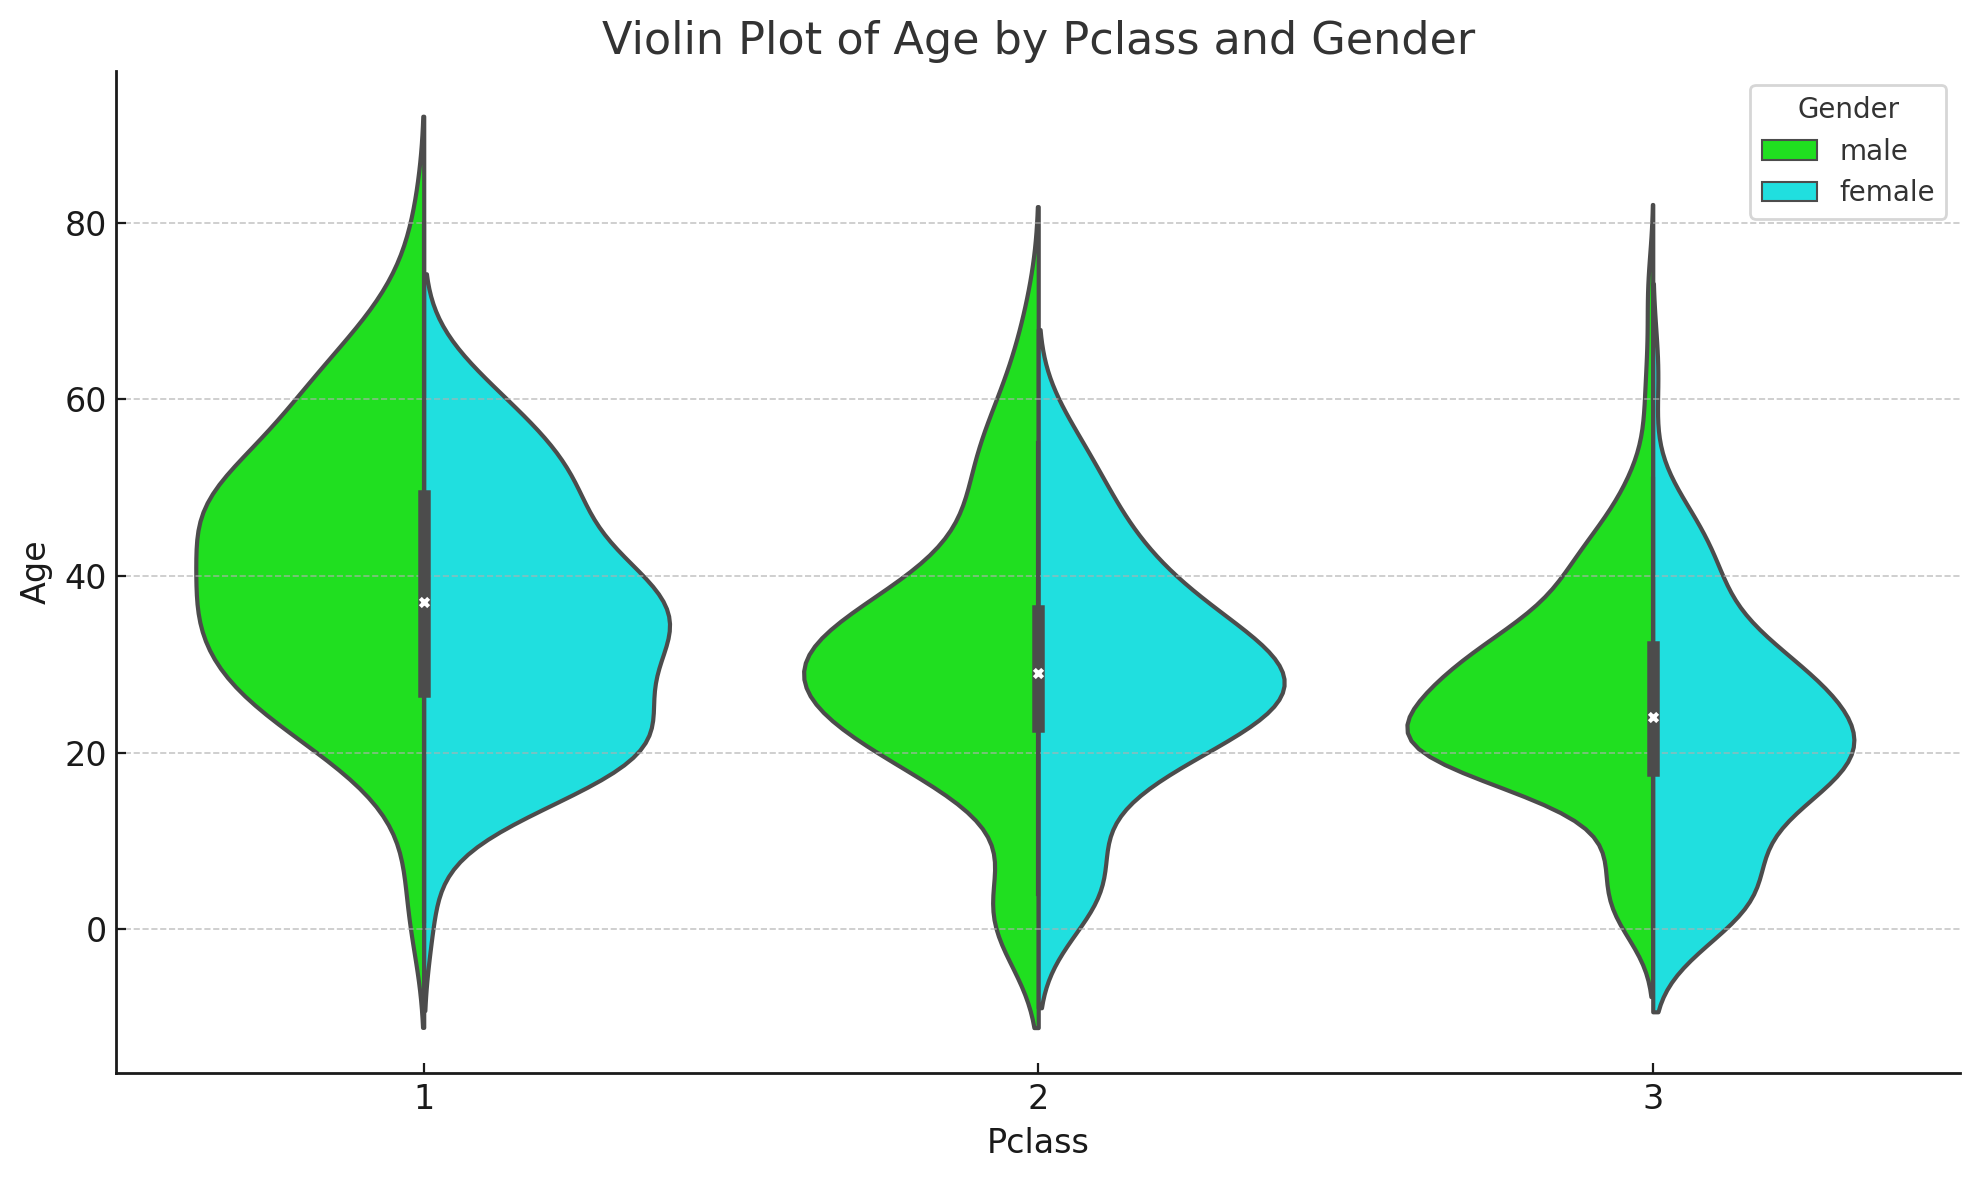

In [29]:
from IPython.display import Image, display
from pathlib import Path

file_path = Path.cwd() / file_name
display(Image(filename=str(file_path)))

## Example

In [30]:
# create a thread
thread = project_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

prompt = "Generate the age distribution. Use lightblue color"

# create a message
message = project_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

Created thread, thread ID: thread_VKOEfIFU0MxrfFwqupDgiFsF
Created message, message ID: msg_Xx3U0G0OJ4CA7mcny7gUQEk5


In [31]:
# create a run for the agent
run = project_client.runs.create_and_process(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

run.usage

Created run, run ID: run_YxzAfwlzNnWHmbkmpjNycSzN


{'prompt_tokens': 2379, 'completion_tokens': 249, 'total_tokens': 2628, 'prompt_token_details': {'cached_tokens': 0}}

In [32]:
    IMAGES_DIR = "images"

    images_list = []

    # [START get_messages_and_save_files]
    messages = project_client.messages.list(thread_id=thread.id)
    print(f"Messages: {messages}")

    for msg in messages:
        # Save every image file in the message
        for img in msg.image_contents:
            file_id = img.image_file.file_id
            file_name = f"{file_id}_image_file.png"
            project_client.files.save(file_id=file_id, file_name=file_name)
            print(f"Saved image file to: {Path.cwd() / file_name}")

        # Print details of every file-path annotation
        for ann in msg.file_path_annotations:
            print("File Paths:")
            print(f"  Type: {ann.type}")
            print(f"  Text: {ann.text}")
            print(f"  File ID: {ann.file_path.file_id}")
            print(f"  Start Index: {ann.start_index}")
            print(f"  End Index: {ann.end_index}")
        # [END get_messages_and_save_files]
        # Print last messages from the thread
        for msg in messages:
            if msg.text_messages:
                last_text = msg.text_messages[-1]
                print(f"{msg.role}: {last_text.text.value}")

Messages: <iterator object azure.core.paging.ItemPaged at 0x1212ee140>
Saved image file to: /Users/arturoquiroga/GITHUB/AZURE AI AGENT SERVICE/1_Azure Agent Service/NOTEBOOKS/assistant-Q7wJWr7c5JhBz4CT174rUj_image_file.png
MessageRole.AGENT: The dataset is from the Titanic, and the "Age" column contains the age information. I will now generate the age distribution using a lightblue color.
MessageRole.AGENT: I will start by examining your file to check its structure and identify the column containing age information. Let's begin by loading and inspecting the data.
MessageRole.USER: Generate the age distribution. Use lightblue color


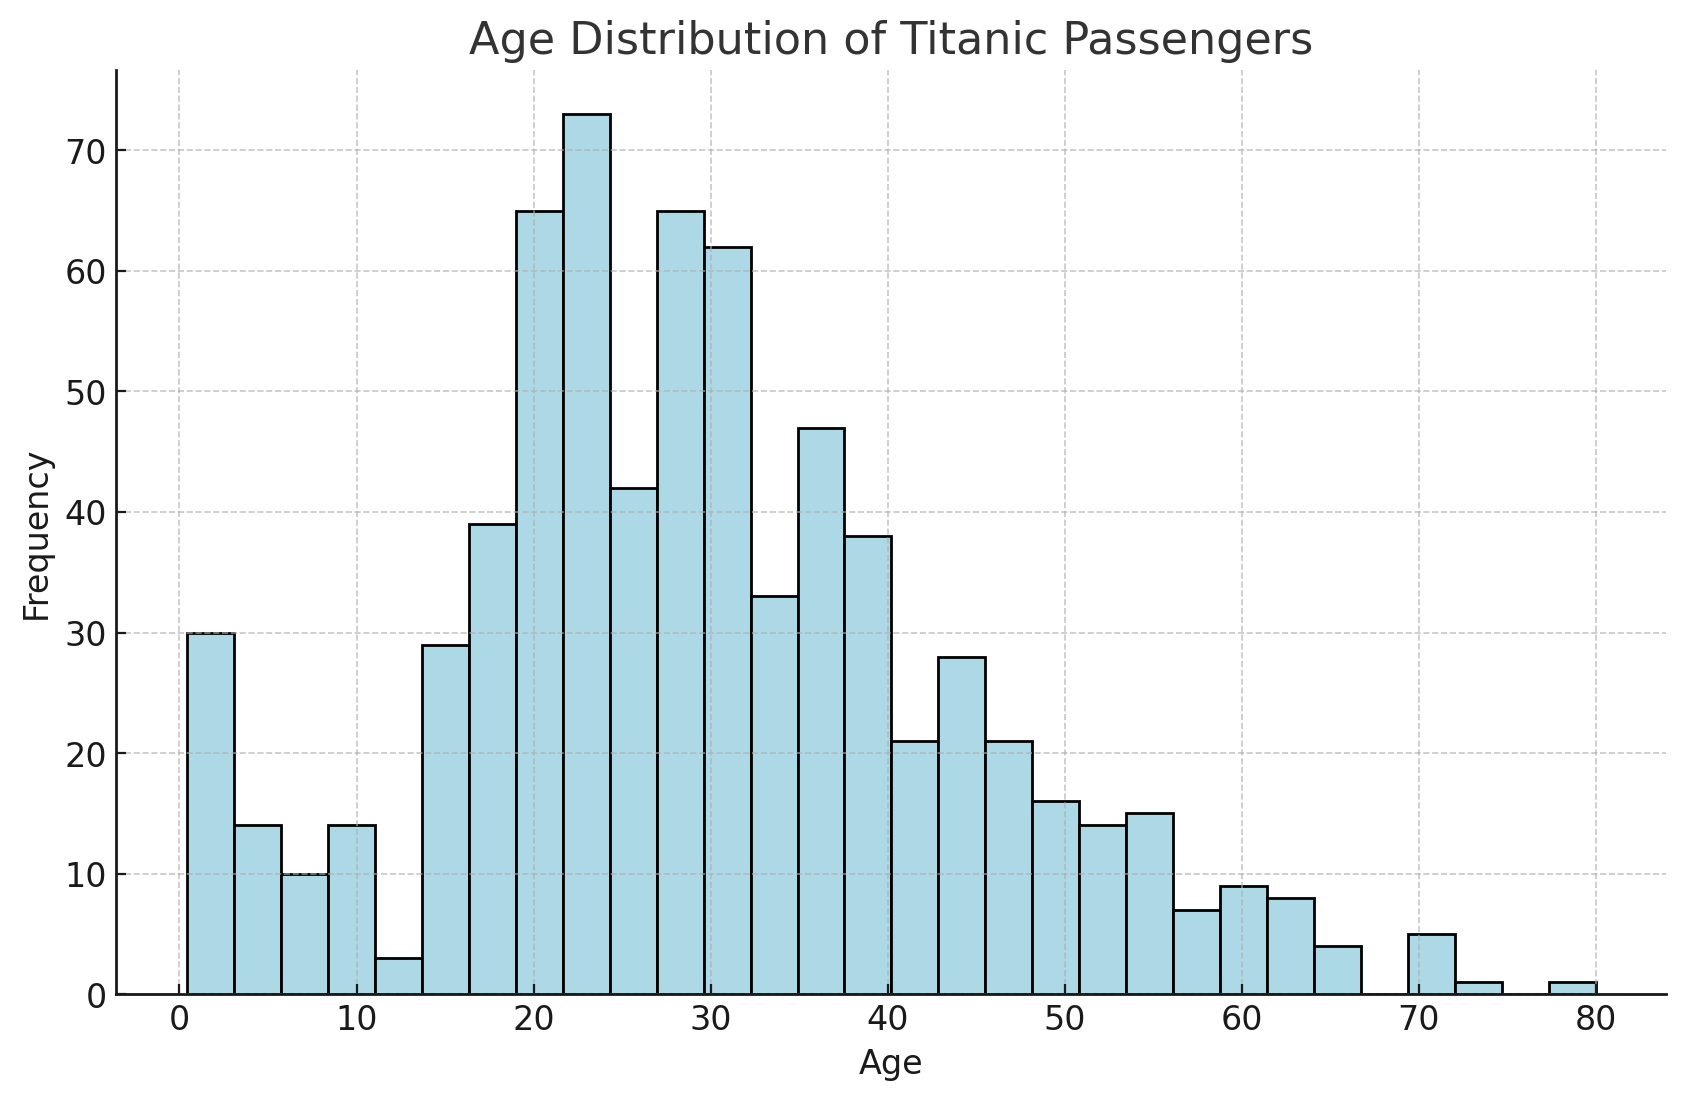

In [33]:
from IPython.display import Image, display
from pathlib import Path

file_path = Path.cwd() / file_name
display(Image(filename=str(file_path)))

## All images

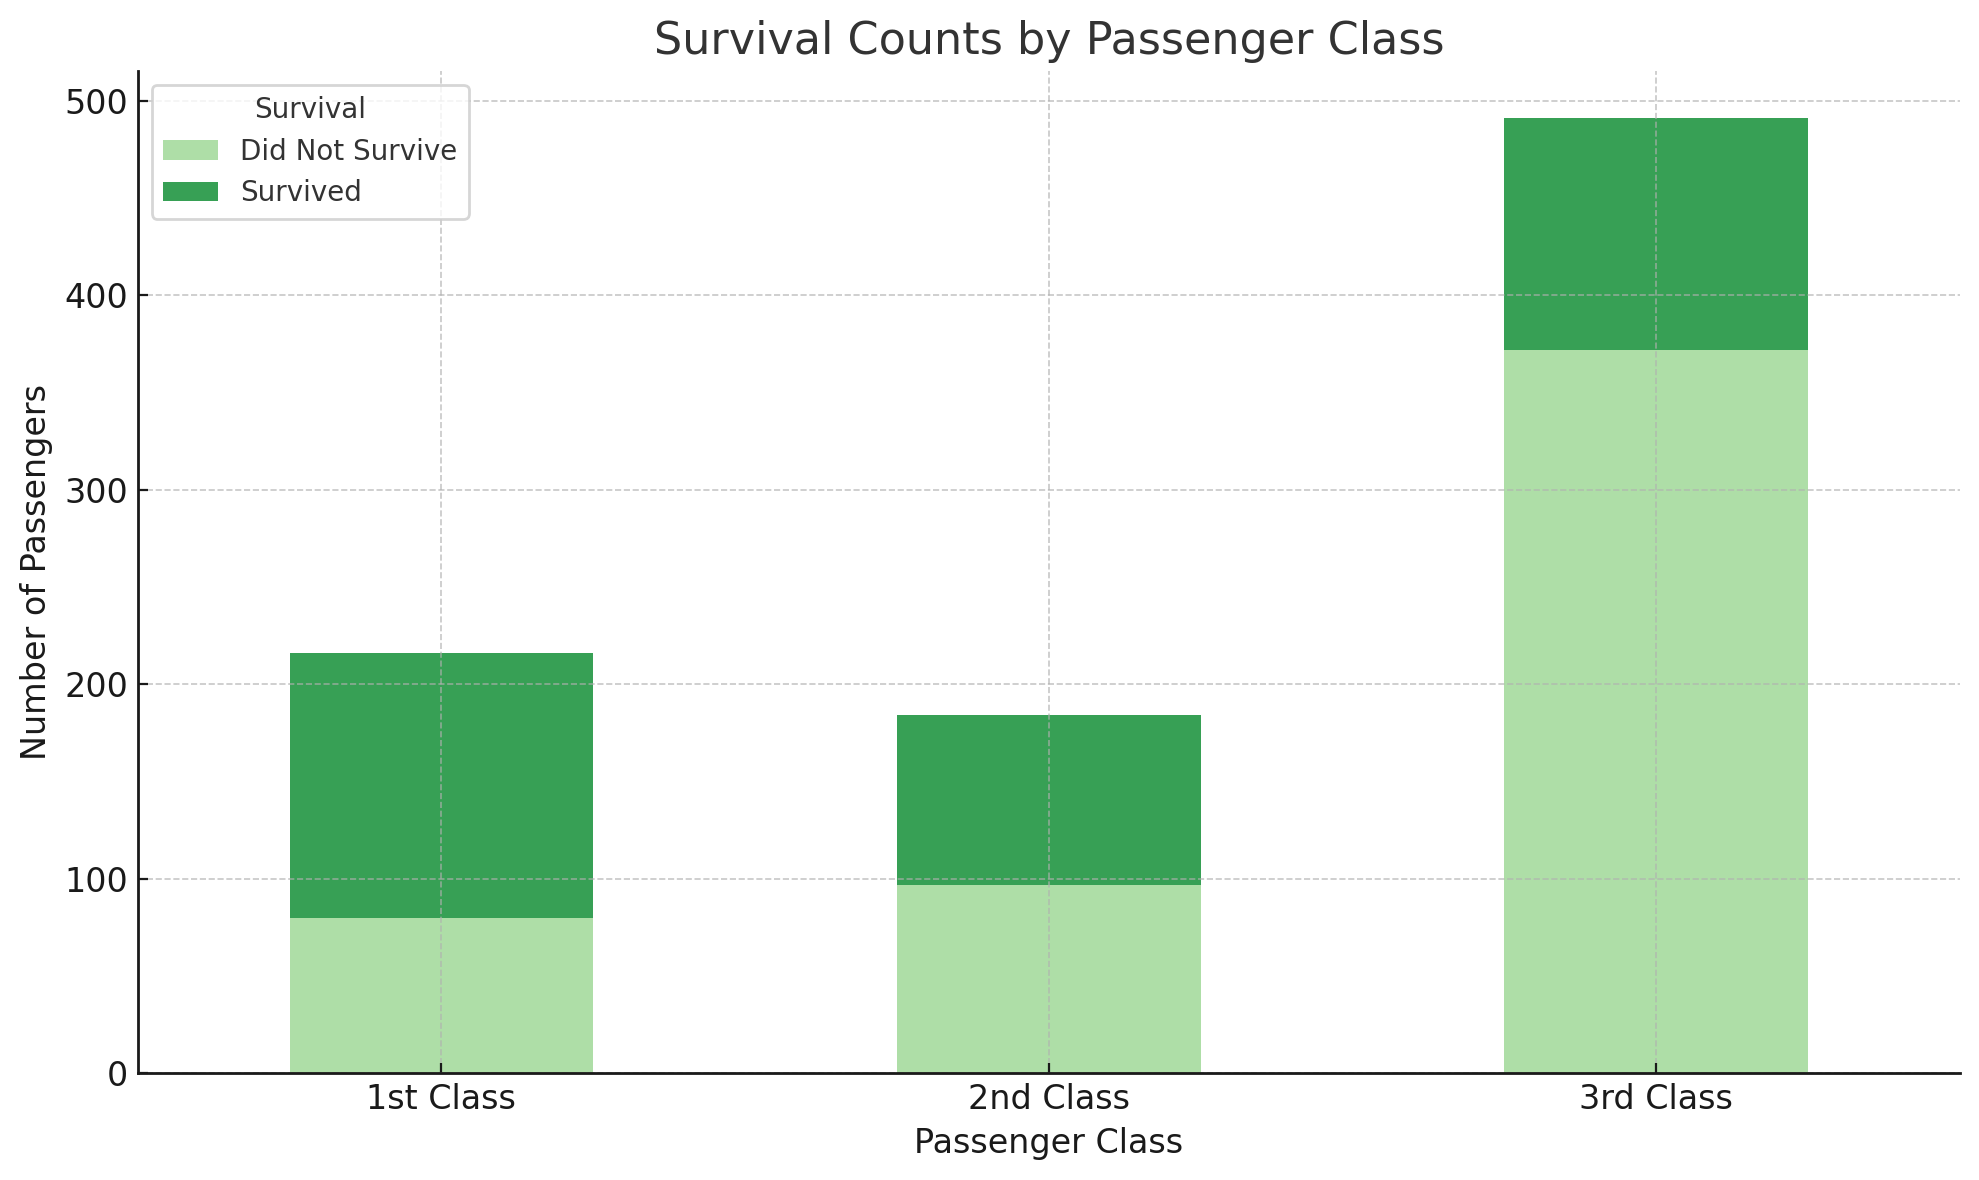

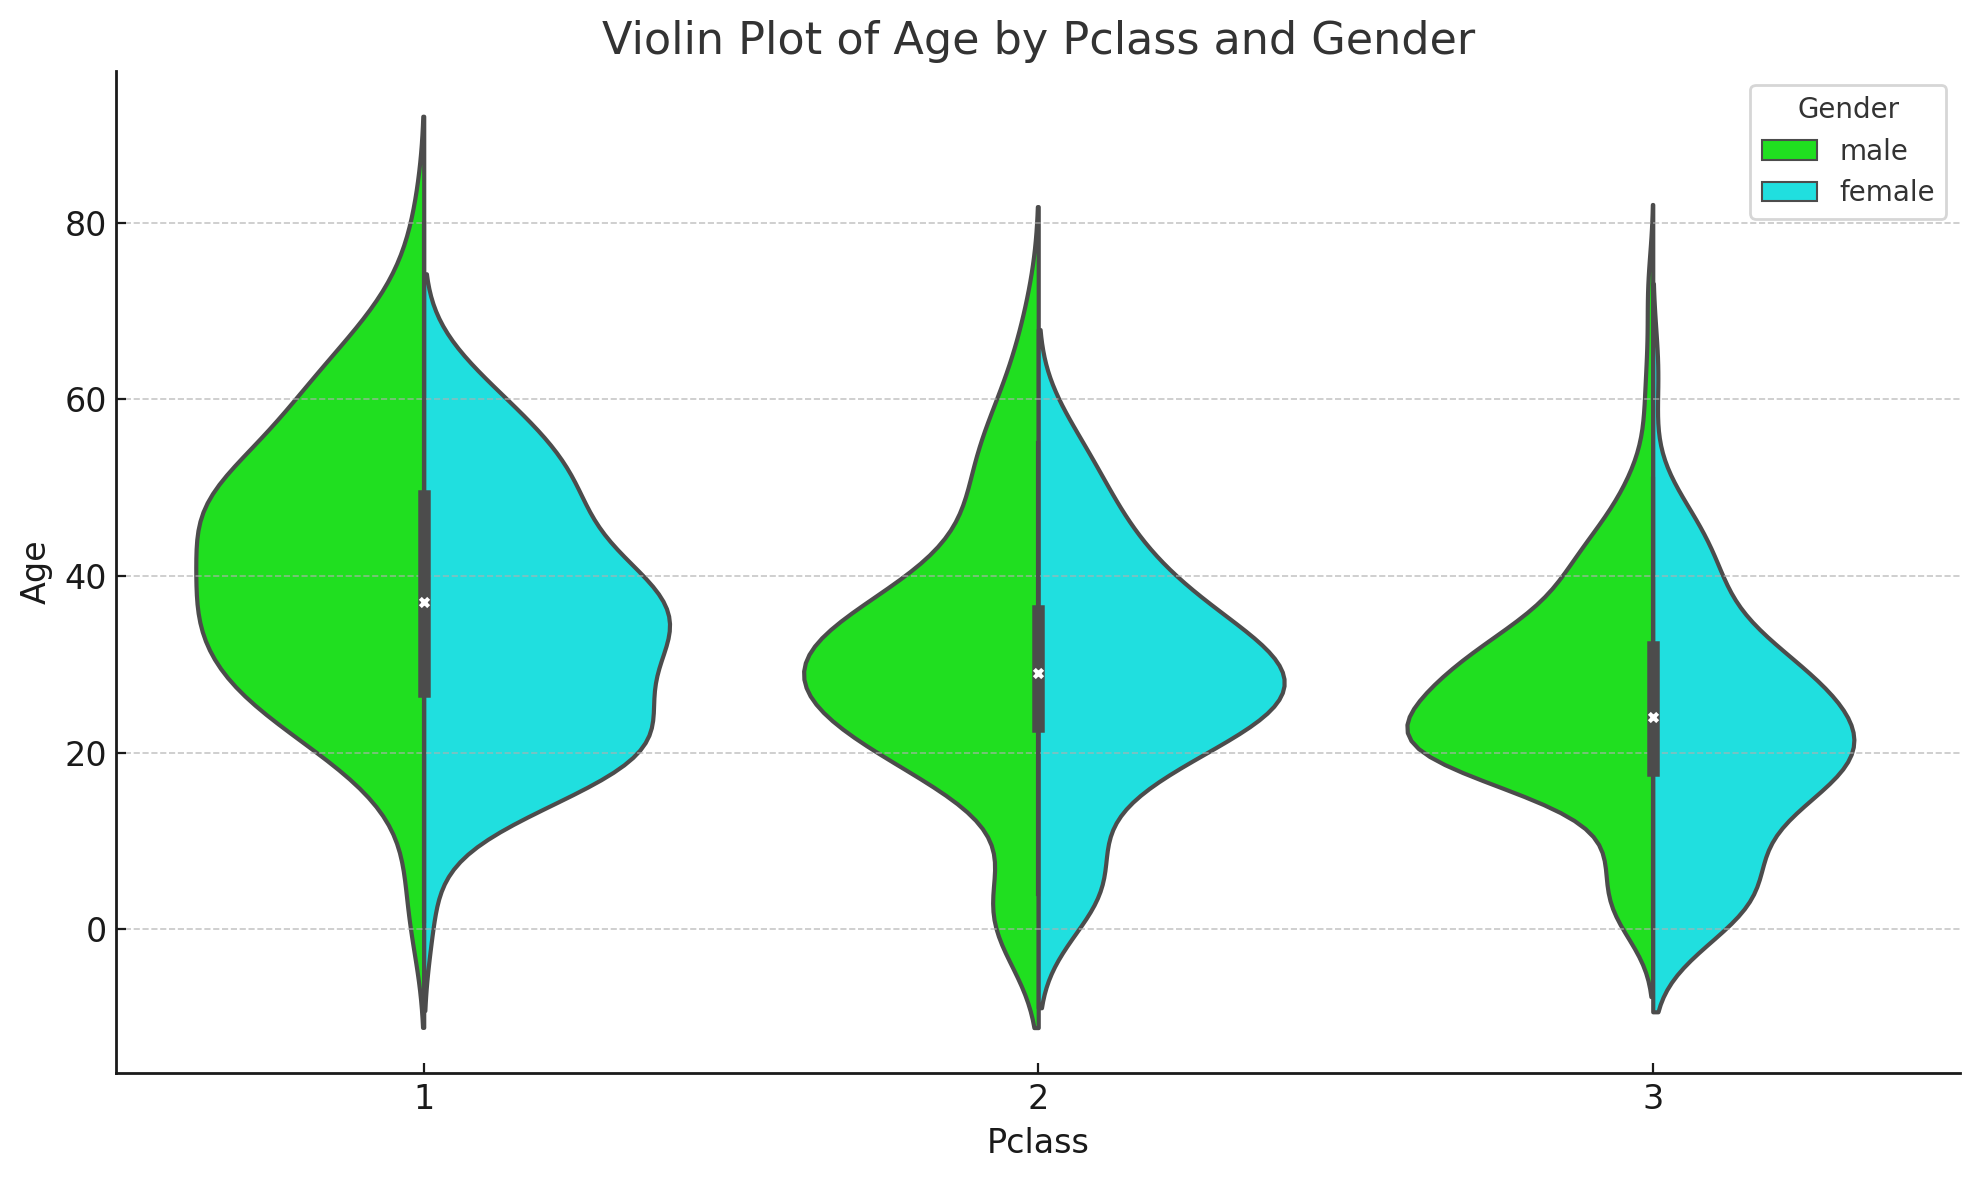

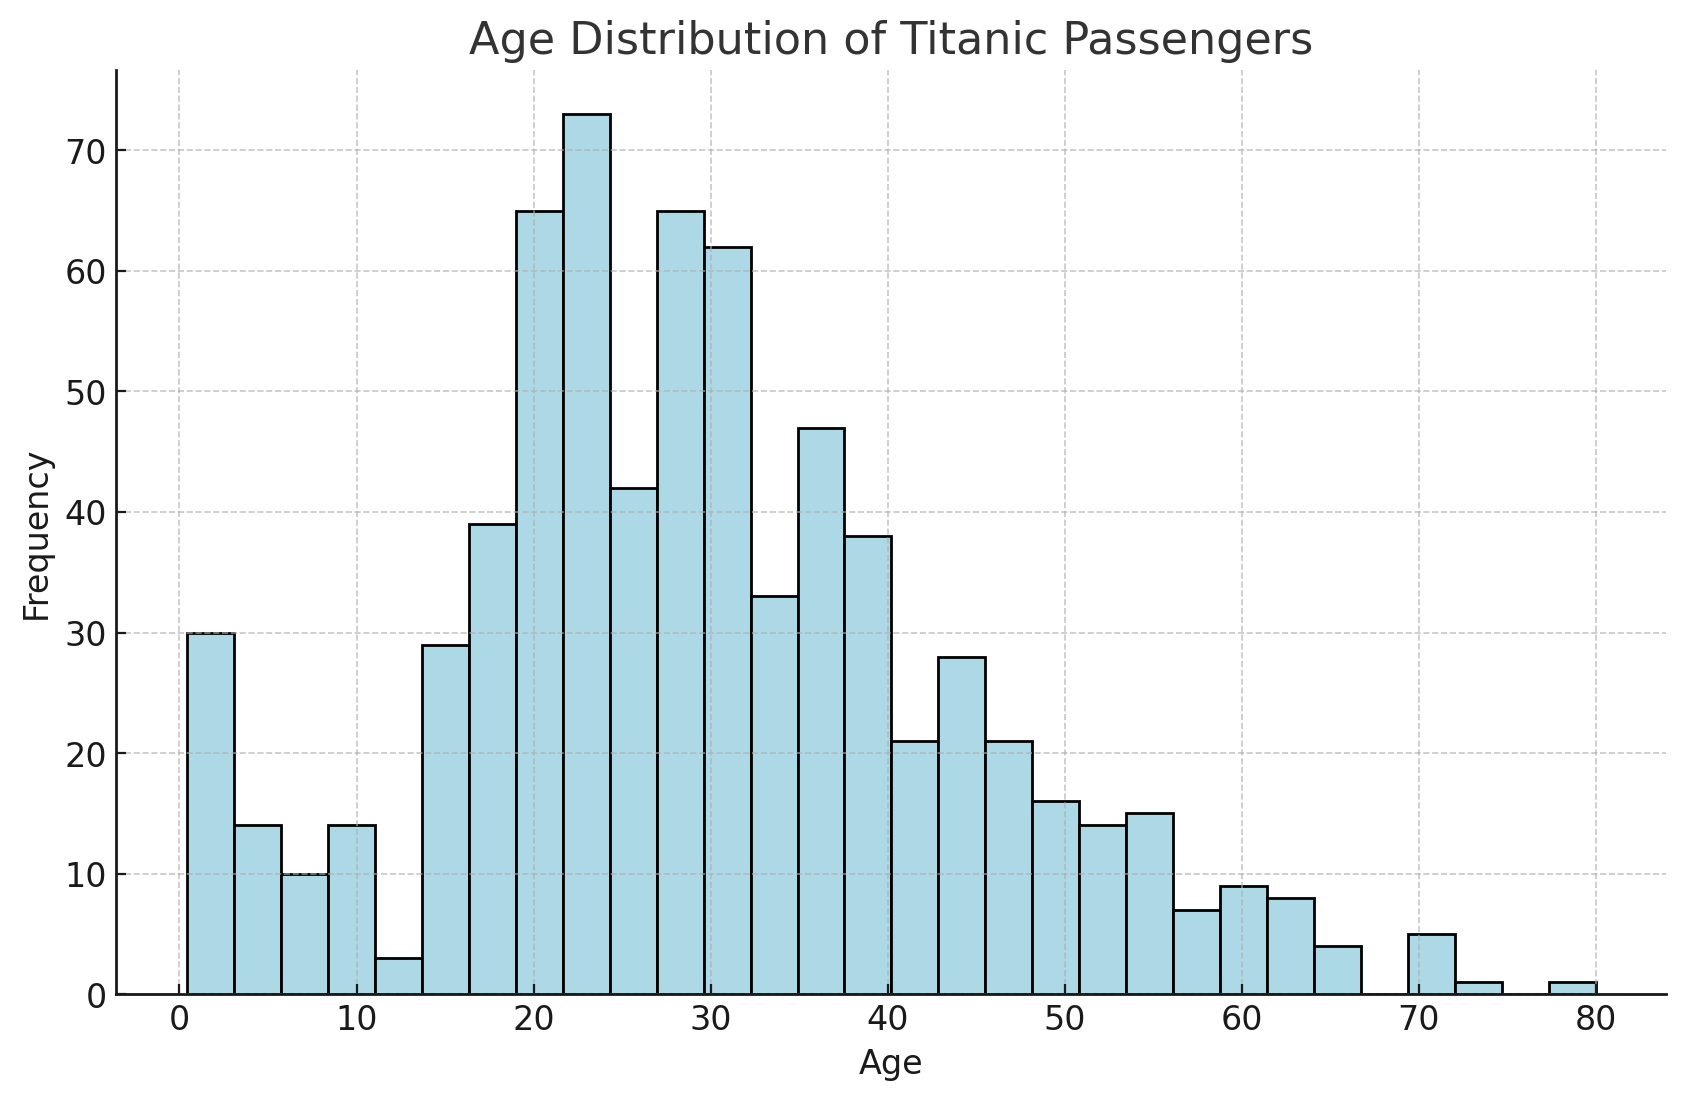

In [34]:
from IPython.display import display, Image
from pathlib import Path

# Define the directory to search for images (current working directory)
image_dir = Path.cwd()

# Find all files matching the pattern 'assistant-*.png'
image_files = sorted(
    [f for f in image_dir.glob('assistant-*.png')],
    key=lambda x: x.stat().st_mtime
)

if image_files:
    for img_path in image_files:
        display(Image(filename=str(img_path)))
else:
    print('No assistant-*.png files found in the current directory.')

## Cleaning

In [ ]:
project_client.delete_agent(agent.id)
print(f"Deleted agent, agent ID: {agent.id}")